In [1]:
import pandas as pd
import numpy as np
import math
import operator
import os
import seaborn as sns

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_digits
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
from keybert._mmr import mmr
from keybert._maxsum import max_sum_distance
from keybert._highlight import highlight_document
from keybert.backend._utils import select_backend
from tqdm import tqdm
from typing import List, Union, Tuple
from matplotlib import pyplot as plt
from scipy import linalg
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2024-08-13 23:03:20.211006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 23:03:20.219251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 23:03:20.229365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin 

In [3]:
model = SentenceTransformer('all-mpnet-base-v2')

In [4]:
pd.options.display.max_colwidth = 250
texts_path = '../Georgian Texts/Vazha Pshavela/'
prose_path = texts_path + 'Prose/revised/'

In [5]:
prose_names = []
sources = ['ge/', 'en/', 'ggl/', 'gem/', 'gpt/']
ge_prose_directory = os.fsencode(prose_path + 'ge/')
for file in sorted(os.listdir(ge_prose_directory)):
    prose_names.append(file.decode())

In [6]:
print('Number of verses')
print('==============================================================================================')
print('ID\tVazha\tHewitt\tGoogle\tGemini\tGem_ru\tChatGPT\tGPT_ru\tPassed?\tProse Name')
for prose in prose_names:
    output = [prose[:2]]
    for source in sources:
        with open(prose_path + source + prose, "r") as file:
            output.append(str(sum(1 for _ in file)))
    if len(set(output[1:])) > 1:
        output.append('No')
    else:
        output.append('Yes')
    output.append(prose[3:-3].replace('_', ' ').title())
    print('\t'.join(output))

Number of verses
ID	Vazha	Hewitt	Google	Gemini	Gem_ru	ChatGPT	GPT_ru	Passed?	Prose Name
21	37	37	37	37	37	Yes	Violet
22	63	63	63	63	63	Yes	The Withered Beech
23	64	64	64	64	64	Yes	The Weeping Rock
24	61	61	61	61	61	Yes	The Lofty Mountains
25	105	105	105	105	105	Yes	The Vulture
26	51	51	51	51	51	Yes	The Forest Was Crying
27	92	92	92	92	92	Yes	The Coarse Grass
28	49	49	49	49	49	Yes	The Mountain Spring
29	44	44	44	44	44	Yes	Roots
30	86	86	86	86	86	Yes	Its Rising Its Getting Light
31	110	110	110	110	110	Yes	A Small Shepherds Thoughts
32	159	159	159	159	159	Yes	The Wedding Of The Jays


In [7]:
verses = []
prose_verse_counts = []
df = pd.DataFrame(
    columns=[
        'Prose ID',
        'Prose Name',
        'Verse',
        'Vazha',
        'Hewitt',
        'Google',
        'Gemini',
        'ChatGPT',
        'Hewitt - Google',
        'Hewitt - Gemini',
        'Hewitt - ChatGPT',
    ]
)

for prose in prose_names:
    prose_id = int(prose[:2])
    prose_name = prose[3:-3].replace('_', ' ').title()

    prose_vazha = [line.strip() for line in open(prose_path + 'ge/' + prose, "r")]
    prose_hewitt = [line.strip() for line in open(prose_path + 'en/' + prose, "r")]
    prose_google = [line.strip() for line in open(prose_path + 'ggl/' + prose, "r")]
    prose_gemini = [line.strip() for line in open(prose_path + 'gem/' + prose, "r")]
    prose_chatgpt = [line.strip() for line in open(prose_path + 'gpt/' + prose, "r")]

    verses.extend(prose_hewitt)
    verses.extend(prose_google)
    verses.extend(prose_gemini)
    verses.extend(prose_chatgpt)

    prose_verse_counts.append(len(prose_vazha))
    for i in range(len(prose_vazha)):
        row = {
            'Prose ID': [prose_id],
            'Prose Name': [prose_name],
            'Verse': [i + 1],
            'Vazha': [prose_vazha[i]],
            'Hewitt': [prose_hewitt[i]],
            'Google': [prose_google[i]],
            'Gemini': [prose_gemini[i]],
            'ChatGPT': [prose_chatgpt[i]]
        }
        df_new = pd.DataFrame(row)
        df = pd.concat([df, df_new], ignore_index = True)

df.shape

(921, 11)

In [8]:
df.to_csv('results/prose/all_texts.csv')

In [9]:
verse_embeddings = model.encode(verses)
verse_embeddings.shape

(3684, 768)

In [10]:
prose_verse_counts

[37, 63, 64, 61, 105, 51, 92, 49, 44, 86, 110, 159]

In [11]:
for i, row in df.iterrows():
    prose_id = row['Prose ID'] - 20
    verse = row['Verse']
    offset = sum(prose_verse_counts[:prose_id-1]) * 4
    j = offset + verse - 1

    hewitt_google = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 1 * prose_verse_counts[prose_id - 1]]]
    )[0][0]
    
    hewitt_gemini = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 2 * prose_verse_counts[prose_id - 1]]]
    )[0][0]

    hewitt_chatgpt = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 3 * prose_verse_counts[prose_id - 1]]]
    )[0][0]

    df.at[i,'Hewitt - Google'] = hewitt_google
    df.at[i,'Hewitt - Gemini'] = hewitt_gemini
    df.at[i,'Hewitt - ChatGPT'] = hewitt_chatgpt

In [12]:
df.head()

,Prose ID,Prose Name,Verse,Vazha,Hewitt,Google,Gemini,ChatGPT,Hewitt - Google,Hewitt - Gemini,Hewitt - ChatGPT
0,21,Violet,1,უღრანს ტყეში მოსული ვარ…,I have sprung to life in a dense forest…,I have come to the dense forest...,I have come to a dense forest...,I have come to the dense forest...,0.802988,0.827873,0.802988
1,21,Violet,2,"მანამ ცოცხალი ვარ, ჩემის სილამაზით დავატკბობ ტყეს, ბალახს და იმ გაღმიდამ გამომცქერალს გულხავსიანს კლდესა, სუნელებას მივაფრქვევ არე-მარეს.","While I live, with my beauty I shall bring sweetness to the forest, the grass and that rock which gazes over from across the river, with its bosom clothed in moss; I shall spread my delightful aroma all around.","As long as I am alive, I will sweeten the forest, the grass, and the mossy rock with my beauty, I will sprinkle spices on the surroundings.","As long as I am alive, I will delight the forest, the grass, and that heart-shaped rock looking at me from afar with my beauty, I will spread fragrance around.","As long as I am alive, I will grace the forest, the grass, and that rough cliff watching from afar with my beauty. I will spread my fragrance to the surroundings.",0.831107,0.876884,0.846976
2,21,Violet,3,"ყველას ვუყვარვარ: აგერ იმ დამპალს ყუნჭს თვალი სულ ჩემსკენ უჭირავს, მიცინის ხოლმე, უნდა ჩემთან მოვიდეს, – მაკოცოს, მაგრამ არ შეუძლიან, მხოლოდ შორიდამ გამიცინებს, გაიღიმება საცოდავი, თუმცა უშნოდ, მაგრამ გულკეთილობა კი დიდი გადაეფინება ხოლმე პირზედ.","I am loved by all; just here that rotting tree-stump has its eye constantly fixed on me; it laughs in my direction and wants to come over — to kiss me, but it can’t; only from a distance will it continue to laugh and smile at me, poor thing; it m...","Everyone loves me: if that rotten bastard keeps his eyes on me, he laughs at me, he wants to come to me, - kiss me, but he can't, he only laughs at me from afar, he smiles pitifully, although ugly, but the kindness is sometimes reflected on his f...","Everyone loves me: that rotten stump over there has its eyes fixed on me, it smiles at me sometimes, it wants to come to me - to kiss me, but it can't, it just smiles at me from afar, the poor thing will smile, even though it's ugly, but great ki...","Everyone loves me: look at that rotting stump, its eyes always fixed on me, it smiles sometimes, wanting to come closer, to kiss me, but it cannot; it only smiles at me from a distance, poor thing, though unattractive, a great kindness spreads ov...",0.67326,0.854383,0.889966
3,21,Violet,4,განა მარტო იმას უხარიან ჩემი სიცოცხლე?,And do you think it’s only that stump which rejoices in my existence?,Is that the only reason they enjoy my life?,Is it only him who is happy with my life?,Is it only that which rejoices in my life?,0.301155,0.290536,0.521672
4,21,Violet,5,"წვერხმელი ხეებიც მე დამხარიან ზევიდამ, თვითონ თავშიშველნი, ტოტებს მე მაფარებენ: ჩვენს იას არ შეგვიცივდეს, ან არაფერმა არ აწყინოსო.","The trees too with their dry, beard-like foliage joyfully look down on me from above — themselves bare-headed, they cover me with their branches: “Our little violet mustn’t catch cold; nothing must upset her,” they say.","Even the topless trees are leaning on me from above, they themselves are bare, their branches cover me: let not our yew get cold, or let nothing freeze.","The bearded trees also lean towards me from above, themselves bareheaded, they cover me with their branches: Let our violet not catch a cold, or let nothing hurt it.","Even the dead trees support me from above, themselves bare-headed, they cover me with their branches: ""Let our violet not get cold, or be harmed by anything.""",0.765149,0.871555,0.825085


In [13]:
df.to_csv('results/prose/similarity/cosine_similarity.csv')

In [14]:
# maximum_difference_easwaran_gandhi.to_csv('/content/drive/MyDrive/religious_texts/semantic analysis/all-mpnet-base-v2/easwaran gandhi.csv')
# maximum_difference_gandhi_purohit.to_csv('/content/drive/MyDrive/religious_texts/semantic analysis/all-mpnet-base-v2/gandhi purohit.csv')
# maximum_difference_purohit_easwaran.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/purohit_google.csv')
# df.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/cosine similarity - sklearn.csv')
# df_max_sum_cs.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/max_sum_in_every_chapter.csv')
# df_min_sum_cs.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/least_sum_in_every_chapter.csv')
# df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/cosine_similarity.csv')

In [15]:
maximum_difference_hewitt_google = df.loc[(df['Hewitt - Google'] < 0.5)]
maximum_difference_hewitt_google.shape

(177, 11)

In [16]:
maximum_difference_hewitt_gemini = df.loc[(df['Hewitt - Gemini'] < 0.5)]
maximum_difference_hewitt_gemini.shape

(53, 11)

In [17]:
maximum_difference_hewitt_chatgpt = df.loc[(df['Hewitt - ChatGPT'] < 0.5)]
maximum_difference_hewitt_chatgpt.shape

(57, 11)

In [18]:
maximum_difference = df.loc[(df['Hewitt - Google']<0.5) & (df['Hewitt - Gemini'] < 0.5) & (df['Hewitt - ChatGPT'] < 0.5)]
maximum_difference

,Prose ID,Prose Name,Verse,Vazha,Hewitt,Google,Gemini,ChatGPT,Hewitt - Google,Hewitt - Gemini,Hewitt - ChatGPT
29,21,Violet,30,მე და სასუტელას კანკალი მოგვივიდა…,This sent a shiver through me and the foxglove…,Sasutela and I got shivers...,Me and Sasutela shivered...,My friend and I shivered...,0.378327,0.448421,0.477407
132,23,The Weeping Rock,33,"სხვაფრივ კარგაა, მთელია თავით, გულ-მკერდით, ძირითა.","Else it is well, whole in head, in breast and foundation.","Everything else is good With head, heart, chest, bottom.","Otherwise, it's good, it's whole With head, heart, root.","Otherwise, it is well, whole in head, heart, and base.",0.410904,0.460694,0.490755
176,24,The Lofty Mountains,13,"ელოდენ, ელიან და კვლავ ექნებათ მოლოდინი.","Expectant in the past, expectant now, and again in the future expectancy will be their lot.","They are waiting, they are waiting and they will be waiting again.","They wait, they wait, and they will wait again.","They wait, they wait and they will continue to wait.",0.461575,0.470641,0.484076
219,24,The Lofty Mountains,56,"რაღაცას. დიაღ, რაღაცას.","For something, surely, for something.","or what something Yes, something.","Something. Yes, something.","Something. Yes, something.",0.366156,0.443341,0.443341
236,25,The Vulture,12,"ნეტავი ერთი ლუკმა მაინც გამოვიდოდეს და მერე ეთქვა ჩემზე აუგი სიტყვა, მერე დავეძრახე.","Would that she were to provide me with one good meal, and then we’d see how she’d malign and censure me!","I wish that at least one bite would come out and then he would say something bad about me, then I would move on.","I wish he could get at least one bite, and then speak ill of me, then I'd curse him.","If only it could become a mouthful and then dare to speak ill of me, then let it be cursed.",0.304641,0.393773,0.329113
240,25,The Vulture,16,"ჟღურტულებს თურმე მძინარა, თვალებდახუჭული.","It seems she sleeps, has her eyes shut, while gibbering.",It turns out that I was sleeping with my eyes closed.,"He whispers, half-asleep, with his eyes closed.","It chirps while asleep, with its eyes closed.",0.323042,0.393289,0.490375
298,25,The Vulture,74,შენ ამოიყარე იმისი ჯავრი.,Get your own back on her.,You threw that shit out.,You can vent your anger there.,You take out your anger on it.,0.128139,0.185492,0.313848
317,25,The Vulture,93,გაიჩმუჩნა.,He leaned into the sound.,appeared.,It shuddered.,It shuffled.,0.203747,0.388168,0.180573
362,26,The Forest Was Crying,33,"ვაჰ, ჩემ თავს!",Woe is me!,"wow, to me!",oh my head!,"alas, my pride!",0.275134,0.209939,0.348225
407,27,The Coarse Grass,27,"ისინიც, როგორც მე, ბედკრული, შესტრფიან პირიმზეს.","They, forlorn just like me, greatly love the mountain-heliotrope.","They too, like me, lucky, will meet Pirimze.","they, like me, are unfortunate, longing for the daisy.","they too, like me, are unfortunate, longing for the sun.",0.321714,0.329873,0.381436


In [19]:
df['Sum CS'] = df['Hewitt - Google'] + df['Hewitt - Gemini'] + df['Hewitt - ChatGPT']
df['Max Sum CS'] = df.groupby(['Prose Name'])['Sum CS'].transform('max')
df['Min Sum CS'] = df.groupby(['Prose Name'])['Sum CS'].transform('min')

In [20]:
df_max_sum_cs = df.loc[(df['Max Sum CS'] == df['Sum CS'])]
df_max_sum_cs.head()

,Prose ID,Prose Name,Verse,Vazha,Hewitt,Google,Gemini,ChatGPT,Hewitt - Google,Hewitt - Gemini,Hewitt - ChatGPT,Sum CS,Max Sum CS,Min Sum CS
18,21,Violet,19,"რასაც კი დაინახავს, უნდა რომ თავის სასარგებლოდ მოიხმაროს.","Whatever he sees, he wants to use for his own advantage.","Whatever he sees, he wants to use it for his own benefit.","Whatever he sees, he wants to use it for his own benefit.","Whatever he sees, he wants to use for his own benefit.",0.953822,0.953822,0.955635,2.863278,2.863278,1.113363
68,22,The Withered Beech,32,"მოსტყდება, წაიქცევა, გვერდზე წაწვება, ფესვები გამოჩნდებიან, აღმა თავაჭერილები, თითქოს ლოცულობდენ, ღმერთს ევედრებოდენ, შველასა სთხოვდენო.","It will crack, come crashing down, lie on its side; its roots will be exposed, raised up towards heaven, as though praying and beseeching God, appealing for help.","It will break, fall, be burned to the side, roots will appear, holding their heads up, as if they are praying, begging God for help.","It will fall, fall, lie on its side, the roots will appear, raised up, as if they were praying, begging God, asking for help.","It will break, fall, lie down on its side, its roots will be exposed, pointing upwards as if praying, pleading to God for help.",0.899311,0.89927,0.942607,2.741189,2.741189,1.407097
148,23,The Weeping Rock,49,არავინ.,No-one.,no one,No one.,No one.,0.928647,0.953851,0.953851,2.836348,2.836348,0.985496
181,24,The Lofty Mountains,18,"რატომ არ მღერით, მთებო?!","Mountains, why do you not sing?!","Why don't you sing, mountains?!","Why don't you sing, mountains?!","Why don't you sing, mountains?!",0.939933,0.939933,0.939933,2.8198,2.8198,1.252839
225,25,The Vulture,1,ზაფხული იყო.,It was summer.,It was summer.,It was summer.,It was summer.,1.0,1.0,1.0,3.0,3.0,0.62748


In [21]:
df_min_sum_cs = df.loc[(df['Min Sum CS'] == df['Sum CS'])]
df_min_sum_cs.head()

,Prose ID,Prose Name,Verse,Vazha,Hewitt,Google,Gemini,ChatGPT,Hewitt - Google,Hewitt - Gemini,Hewitt - ChatGPT,Sum CS,Max Sum CS,Min Sum CS
3,21,Violet,4,განა მარტო იმას უხარიან ჩემი სიცოცხლე?,And do you think it’s only that stump which rejoices in my existence?,Is that the only reason they enjoy my life?,Is it only him who is happy with my life?,Is it only that which rejoices in my life?,0.301155,0.290536,0.521672,1.113363,2.863278,1.113363
79,22,The Withered Beech,43,"განა ყველა, რაც ხმელია, კაცისგან საწუნარია?!",Is everything that’s withered really to be despised by man?!,"Is all that is dry, is it possible to complain about a man?!",Is everything that is dry is it contemptible from a man?!,Is everything that is dry to be despised by man?,0.24873,0.452886,0.705481,1.407097,2.741189,1.407097
149,23,The Weeping Rock,50,ერთი მარტო გოშიაა იმისი პატრონი.,Only one small dog attends to him.,There is only one Goshi who owns it,Only one marten is his master,Only his loyal dog,0.23864,0.231129,0.515727,0.985496,2.836348,0.985496
219,24,The Lofty Mountains,56,"რაღაცას. დიაღ, რაღაცას.","For something, surely, for something.","or what something Yes, something.","Something. Yes, something.","Something. Yes, something.",0.366156,0.443341,0.443341,1.252839,2.8198,1.252839
298,25,The Vulture,74,შენ ამოიყარე იმისი ჯავრი.,Get your own back on her.,You threw that shit out.,You can vent your anger there.,You take out your anger on it.,0.128139,0.185492,0.313848,0.62748,3.0,0.62748


In [22]:
print('Relation\tmean\t\t\tstd')
print(f"Hewitt-Google\t{df['Hewitt - Google'].mean()}\t{df['Hewitt - Google'].std()}")
print(f"Hewitt-Gemini\t{df['Hewitt - Gemini'].mean()}\t{df['Hewitt - Gemini'].std()}")
print(f"Hewitt-ChatGPT\t{df['Hewitt - ChatGPT'].mean()}\t{df['Hewitt - ChatGPT'].std()}")

Relation	mean			std
Hewitt-Google	0.6617079744121539	0.17889741399317496
Hewitt-Gemini	0.7480727867764319	0.14229499911368426
Hewitt-ChatGPT	0.7469095401991721	0.14672443702101104


In [23]:
df_mean_hewitt_google = df.groupby('Prose Name')['Hewitt - Google'].mean().reset_index()
df_mean_hewitt_gemini = df.groupby('Prose Name')['Hewitt - Gemini'].mean().reset_index()
df_mean_hewitt_chatgpt = df.groupby('Prose Name')['Hewitt - ChatGPT'].mean().reset_index()

df_std_hewitt_google = df.groupby('Prose Name')['Hewitt - Google'].std().reset_index()
df_std_hewitt_gemini = df.groupby('Prose Name')['Hewitt - Gemini'].std().reset_index()
df_std_hewitt_chatgpt = df.groupby('Prose Name')['Hewitt - ChatGPT'].std().reset_index()

In [24]:
print('Google', df_std_hewitt_google['Hewitt - Google'].mean())
print('Gemini', df_std_hewitt_gemini['Hewitt - Gemini'].mean())
print('ChatGPT', df_std_hewitt_chatgpt['Hewitt - ChatGPT'].mean())

Google 0.1767653271021268
Gemini 0.14006858354461799
ChatGPT 0.14467116961319584


In [25]:
kw_model = KeyBERT(model = 'all-mpnet-base-v2')

In [32]:
####### METHODOLOGY FOR OBTAINING KEYWORDS

# We encode verses using the MPNet-base model to compute the verse by verse semantic similarity. 
# We use the MPNet-base model for extraction of keywords (using KeyBERT) from all chapters. 
# However, given the constraint in the MPNet-base model that number of tokens should not exceed 384, it would not be possible to encode large chapters directly. 
# Hence, we propose a method to overcome this limitation by breaking each chapter into paragraphs of 15 verses. 
# We include 3 verses from the previous paragraph into the current paragraph to retain some context and maintain continuity. 
# For example, in the first paragraph, verses 1-15 are included, and in the second paragraph verses 13-27, then 25-39, and so on.  
# We keep the top 20 keywords because keywords that have a lower similarity score in the original paragraph may be more relevant when the entire paragraph is considered.
 
# Next, we extract the keywords for all paragraphs i with 20 candidate keywords of paragraph j such that i!=j. 
# For each keyword, we add up its cosine similarity score across paragraphs. 
# Finally, we obtain the top 10 keywords having the highest cumulative scores. 
# The key idea here is that if a term is a keyword in a certain paragraph, it also needs to be sufficiently close to other paragraphs in the higher dimensional vector space
# to qualify as a keyword for the entire chapter. 
# We use MMR with a diversity value of 0.5 to prevent the selection of similar meaning keywords.

In [30]:
top_n = 20
final_df = pd.DataFrame()

for prose in prose_names:
    df = pd.read_csv('results/prose/sentiment/' + 'en/' + prose)
    df = df.drop(['Unnamed: 0', 'Official report', 'Joking'], axis=1)

    score_list = []
    text_list = []
    string_list = []
    keyword_score_map = {}
    keyword_count_map = {}

    for i in range(math.ceil(df.shape[0] / 15)):
        if i == 0:
            text = ' '.join(df[0:15].Tweet)
        else:
            if df.shape[0] >= 15 * (i + 1) - 3:
                text = ' '.join(df[(15 * i - 3):(15 * (i + 1) - 3)].Tweet)
            else:
                text = ' '.join(df[(15 * i - 3):df.shape[0]].Tweet)

        list1 = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=top_n, use_mmr=True, diversity=0.5)
        score_list.append(list1)
        text_list.append(text)

        for jj in range(0, top_n):
            keyword = score_list[0][jj][0]
            string_list.append(keyword)
            keyword_score_map[keyword] = 0
            keyword_count_map[keyword] = 0

    for ii in range(math.ceil(df.shape[0] / 15)):
        for jj in range(math.ceil(df.shape[0] / 15)):
            list2 = kw_model.extract_keywords(
               text_list[jj], 
               candidates=string_list[top_n * ii:top_n * (ii + 1)], 
               keyphrase_ngram_range=(1, 1), 
               stop_words='english', 
               top_n=top_n,
               use_mmr=True,
               diversity=0.3
            )
            for kk in range(0, len(list2)):
                keyword = list2[kk][0]
                keyword_score = list2[kk][1]
                keyword_score_map[keyword] += keyword_score
                keyword_count_map[keyword] += 1

    keyword_score_map = dict( sorted(keyword_score_map.items(), key=operator.itemgetter(1), reverse=True))     # sort in descending order according to scores
    keyword_df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])                         # convert dictionary to dataframe
    keyword_df = keyword_df[:5]                                                                                # TOP 10 KEYWORDS most relevant to text 
    keyword_df['Prose'] = prose[3:-3].replace('_', ' ').title()
    keyword_df['Author'] = 'Hewitt'

    final_df = pd.concat([final_df, keyword_df], axis=0)

final_df.to_csv('results/prose/keywords/en/keywords.csv')

In [31]:
df_keywords_en = pd.read_csv('results/prose/keywords/en/keywords.csv')
df_keywords_ggl = pd.read_csv('results/prose/keywords/ggl/keywords.csv')
df_keywords_gem = pd.read_csv('results/prose/keywords/gem/keywords.csv')
df_keywords_gpt = pd.read_csv('results/prose/keywords/gpt/keywords.csv')

df_keywords_en = df_keywords_en.drop(['Unnamed: 0', 'Score', 'Author'], axis=1)
df_keywords_en = df_keywords_en.reindex(columns=['Prose', 'Keyword'])
df_keywords_en = pd.concat([
        df_keywords_en,
        df_keywords_ggl['Keyword'],
        df_keywords_gem['Keyword'],
        df_keywords_gpt['Keyword']
    ],     
    axis=1
)
df_keywords_en.columns = ['Prose', 'Hewitt', 'Google', 'Gemini', 'ChatGPT']
df_keywords_en.to_csv('results/prose/keywords/all.csv')

In [32]:
keyword_dict = dict()
for i, row in df_keywords_en.iterrows():
    poem = row['Prose']
    if poem not in keyword_dict:
        keyword_dict[poem] = {"Hewitt": set(), "Google": set(), "Gemini": set(), "ChatGPT": set()}
    keyword_dict[poem]["Hewitt"].add(row["Hewitt"])
    keyword_dict[poem]["Google"].add(row["Google"])
    keyword_dict[poem]["Gemini"].add(row["Gemini"])
    keyword_dict[poem]["ChatGPT"].add(row["ChatGPT"])

keyword_count = dict()
for poem in keyword_dict.keys():
    keyword_count[poem] = {"Google": 0, "Gemini": 0, "ChatGPT": 0}
    keyword_count[poem]["Google"] = len(keyword_dict[poem]["Hewitt"].intersection(keyword_dict[poem]["Google"]))
    keyword_count[poem]["Gemini"] = len(keyword_dict[poem]["Hewitt"].intersection(keyword_dict[poem]["Gemini"]))
    keyword_count[poem]["ChatGPT"] = len(keyword_dict[poem]["Hewitt"].intersection(keyword_dict[poem]["ChatGPT"]))

model_count = {"Google": 0, "Gemini": 0, "ChatGPT": 0}
for _, model in keyword_count.items():
    model_count["Google"] += model["Google"]
    model_count["Gemini"] += model["Gemini"]
    model_count["ChatGPT"] += model["ChatGPT"]

model_count

{'Google': 16, 'Gemini': 22, 'ChatGPT': 20}

In [33]:
round(20 / 60 * 100, 2)

33.33

In [34]:
df = pd.read_csv('results/prose/keywords/en/keywords.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(subset='Keyword', keep='last', inplace=True)

onlykey = df.loc[(df['Author'] == 'Hewitt')]
onlykey=onlykey['Keyword']
onlykey

0         portends
2           father
3     leaflessness
4            stump
6            trees
7      consolation
8             tale
9      nourishment
10          nature
11          valley
12        thousand
13           merit
14          merely
15      expectancy
16       mountains
17           deity
18     countenance
19           await
20        vultures
21         carrion
22         perched
23         praises
24      pestilence
25            deer
26           cawed
27           kebab
28          tastes
29           heard
30        mountain
31           grass
33           weeps
34            fall
35             god
36          spring
37            flow
38        boulders
39           faced
40           earth
41             oak
42        withered
43          snakes
44           roots
45        ravenous
46          forest
47            snow
48           night
49         howling
50           sheep
51            away
52          family
53            didq
54          ighuna
55          

In [35]:
onlykey.to_csv('results/prose/keywords/en/onlykey.tsv', sep='\t', index=None, header=None)

In [36]:
keyword_score_map = dict(sorted(keyword_score_map.items(), key=operator.itemgetter(1), reverse=True))

In [37]:
df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])
df.head()

,Keyword,Score
0,birds,40.3623
1,bride,17.2348
2,feast,16.1106
3,worm,7.3216
4,seeds,6.9685


In [38]:
model = KeyBERT(model='all-mpnet-base-v2')
model

In [39]:
df = pd.read_csv('results/prose/keywords/en/keywords.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(subset='Keyword', keep='last', inplace=True)
df

,Keyword,Score,Prose,Author
0,portends,1.7469,Violet,Hewitt
2,father,1.1502,Violet,Hewitt
3,leaflessness,1.1346,Violet,Hewitt
4,stump,1.0941,Violet,Hewitt
6,trees,6.9270,The Withered Beech,Hewitt
7,consolation,3.6230,The Withered Beech,Hewitt
8,tale,3.1700,The Withered Beech,Hewitt
9,nourishment,2.5305,The Withered Beech,Hewitt
10,nature,4.5310,The Weeping Rock,Hewitt
11,valley,4.4120,The Weeping Rock,Hewitt


In [40]:
candidates = df['Keyword'].tolist()
candidates

['portends',
 'father',
 'leaflessness',
 'stump',
 'trees',
 'consolation',
 'tale',
 'nourishment',
 'nature',
 'valley',
 'thousand',
 'merit',
 'merely',
 'expectancy',
 'mountains',
 'deity',
 'countenance',
 'await',
 'vultures',
 'carrion',
 'perched',
 'praises',
 'pestilence',
 'deer',
 'cawed',
 'kebab',
 'tastes',
 'heard',
 'mountain',
 'grass',
 'weeps',
 'fall',
 'god',
 'spring',
 'flow',
 'boulders',
 'faced',
 'earth',
 'oak',
 'withered',
 'snakes',
 'roots',
 'ravenous',
 'forest',
 'snow',
 'night',
 'howling',
 'sheep',
 'away',
 'family',
 'didq',
 'ighuna',
 'birds',
 'bride',
 'feast',
 'worm',
 'seeds']

In [41]:
doc,candidate_embeddings = model.extract_embeddings(candidates)

print(len(candidate_embeddings))
print(len(candidate_embeddings[0]))

57
768


In [42]:
candidate_embeddings

array([[-2.82010045e-02,  8.53977948e-02, -4.44622003e-02, ...,
         2.28145216e-02, -1.74746923e-02, -1.19033186e-02],
       [-5.64731052e-03,  5.95311187e-02, -3.50776836e-02, ...,
         9.13870186e-02, -6.44716769e-02,  3.74360047e-02],
       [ 8.07294995e-03,  5.31020798e-02, -2.18656659e-02, ...,
         5.95184341e-02,  1.98303256e-02,  7.37974560e-03],
       ...,
       [ 6.31925650e-05,  5.42203933e-02, -1.39005587e-03, ...,
         2.91684624e-02, -3.34843844e-02, -1.05403569e-02],
       [ 1.13121113e-02,  6.49861200e-03,  6.59491401e-03, ...,
        -3.04234196e-02, -1.52496276e-02, -1.07491985e-02],
       [ 1.65901631e-02,  1.39642153e-02, -2.44574796e-04, ...,
         1.03435479e-03, -2.01988276e-02, -2.50313375e-02]], dtype=float32)

In [43]:
candidate_embeddings = pd.DataFrame(candidate_embeddings)
candidate_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.028201,0.085398,-0.044462,0.041155,-0.050704,-0.012619,-0.037594,-0.001488,-0.001844,0.025250,...,-0.000872,0.018075,0.089570,-0.002592,-0.032900,0.052511,-0.030509,0.022815,-0.017475,-0.011903
1,-0.005647,0.059531,-0.035078,0.005772,-0.024095,-0.008497,-0.024978,-0.032025,-0.077164,0.032149,...,-0.000560,-0.003854,0.061149,-0.004115,-0.008580,0.017675,0.022871,0.091387,-0.064472,0.037436
2,0.008073,0.053102,-0.021866,-0.041354,-0.041015,0.006636,-0.022608,-0.020232,-0.059951,-0.006956,...,0.018004,-0.037512,0.005971,-0.038487,0.008026,-0.013930,-0.022649,0.059518,0.019830,0.007380
3,0.034976,-0.006121,-0.037273,0.022007,0.008324,-0.007284,-0.023028,0.017152,0.053730,0.013991,...,-0.023452,0.004911,-0.042833,-0.019144,-0.007809,0.041149,-0.037014,0.064249,-0.012231,0.007404
4,0.028615,0.026186,0.007258,0.027971,-0.060379,-0.046200,-0.059320,0.029105,0.028729,0.001331,...,-0.000347,-0.009238,0.074101,0.032571,-0.024973,0.060639,0.002479,0.018108,0.004349,0.008094
5,-0.019436,-0.005518,-0.019284,0.016239,-0.022884,0.009382,-0.038526,0.015774,0.036430,-0.011042,...,-0.070192,-0.007532,-0.005033,-0.030181,0.003074,0.059849,-0.027464,0.010613,-0.059076,-0.026744
6,-0.023885,0.018963,0.011398,-0.032976,-0.031193,0.011866,0.016320,0.028768,0.027385,-0.013720,...,0.027586,-0.024307,0.000239,0.014195,-0.014359,0.027228,-0.039287,0.027366,0.013263,0.009228
7,0.008499,0.072371,-0.001434,-0.002129,-0.031091,-0.003092,-0.023889,-0.039303,-0.075396,0.011013,...,0.011995,-0.014623,0.064506,-0.001157,-0.025668,-0.021152,-0.037689,0.020151,0.010888,-0.026650
8,-0.001060,0.084145,0.001890,-0.006168,-0.032442,0.029959,-0.030407,0.029269,0.033477,0.030618,...,-0.060620,-0.000945,0.039515,0.006828,-0.025483,0.067493,0.031405,0.062668,-0.040010,-0.017341
9,0.015842,0.003216,-0.001821,-0.006446,-0.029484,0.013066,-0.045222,0.021535,0.003158,-0.042017,...,0.021198,-0.030476,0.010577,0.001167,-0.000714,0.077919,-0.019920,0.062695,0.024146,-0.014706


In [44]:
candidate_embeddings.to_csv('results/prose/keywords/hewitt_keywords_all.tsv', sep='\t', index=None, header=None)
df.to_csv('results/prose/keywords/hewitt_metadata.tsv', index=False, sep='\t')

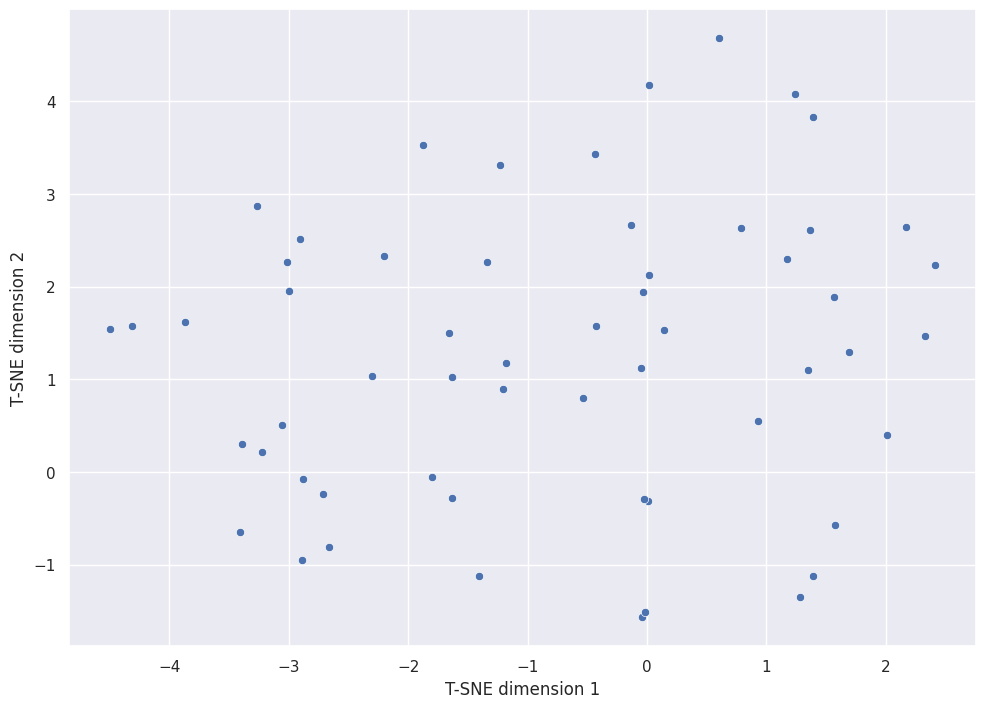

In [45]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
tsne = TSNE(perplexity=30)
X_embedded = tsne.fit_transform(candidate_embeddings)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], legend='full')
plt.xlabel(xlabel='T-SNE dimension 1')
plt.ylabel(ylabel='T-SNE dimension 2')
plt.show()